# Laborator 4: model de regresie liniara

## Descriere

Descrierea problemei si a setului de date se gasesc in `data/Concrete_Readme.txt`. Setul de date este in fisierul `/data/Concrete_Data.xls`. Se va aplica model de regresie liniara pentru estimarea valorii de "Concrete compressive strength" (ultima coloana din setul de date), folosind ca intrari valorile din celelalte 8 coloane. 

Implementarea se va face folosind functii de NumPy. Se va folosi calcul vectorizat, pe cat posibil. 

**Termen de lucru: 3 săptămâni**

Predarea temei se va face în perioada **12-15 noiembrie**, conform termenului limită alocat diferențiat pe grupe, de pe platforma elearning.


Cerinte si precizari:
1. Studentii se pot consulta intre ei, dar rezolvarile vor fi individuale. Necunoasterea codului prezentat inseamna nota 1 pentru tema curenta. 
2. Se se faca adnotari de tipuri pentru variabilele folosite, parametrii de intrare ai functiilor si tipurile de retur. Neindeplinirea acestei cerinte duce la injumatatirea notei.

## Importarea bibliotecilor, citirea datelor folosind Pandas dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Tuple, Any

import numpy as np

import matplotlib.pyplot as plt

# pentru citire de fisier excel
!pip install xlrd  

In [2]:
data_path = './data/Concrete_Data.xls'
data = pd.read_excel(data_path)
assert data.shape == (1030, 9), f'Fisierul nu a fost citit corect: s-a citit un continut de forma {data.shape}'

In [3]:
# afisarea primelor 5 linii din dataframe

data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
# in matricea X vom avea valorile pentru trasaturile de intrare
# in vectorul y vor fi valorile de iesire asociate
# in ambele situatii: numpy arrays. In mod convenabil, y va fi vector coloana

X:np.ndarray = data.iloc[:, 0:-1].values
y:np.ndarray = data.iloc[:, -1].values.reshape(-1, 1)


## Functii pentru date

Functia de mai jos este folosita pentru a face o permutare aleatoare a datelor initiale. 

In [5]:
def random_shuffle(X:np.ndarray,y:np.ndarray)->tuple:
    """
    This function shuffles the elements of two ndarrays randomly.
    It returns a tuple of ndarrays.
    """
    # obtinem indicii de linie, permutati
    shuffled_indices:np.ndarray = np.random.permutation(np.arange(data.shape[0])) 
    #(data.shape = (1030,9)->data.shape[0]=1030)
    #np.arrange(1030)->values are generated within the half-open interval [0, 1030) ->ndarray
    #np.random.permutation(...) shuffles the indexes stored in np.arrange(...) -> ndarray
    assert set(shuffled_indices) == set(np.arange(data.shape[0]))
    # se folosesc indicii permutati
    X_shuffled:np.ndarray = X[shuffled_indices]
    y_shuffled:np.ndarray = y[shuffled_indices]
    return X_shuffled, y_shuffled
    
X_shuffled, y_shuffled = random_shuffle(X, y)
assert X_shuffled.shape == X.shape, f'Forme diferite: {X_shuffled.shape}, {X.shape}'
assert y_shuffled.shape == y.shape, f'Forme diferite: {y_shuffled.shape}, {y.shape}'
assert set(y_shuffled[:, 0]) == set(y[:, 0]), f'Valori diferite'

Avem nevoie de o functie care sa faca impartirea unei matrice (sau vector) in doua submatrice (respectiv 2 subvectori), in functie de procent `0 < p < 100` specificat. Functia va returna doua sumbatrice (subvectori), compuse din primele `p%` linii si restul de linii din matrice (vectorul) data. Functia va fi folosita pentru impartirea unui set de date in subset de antrenare si respectiv de testare.

Exmeplu: daca avem matricea `A` de 200 de linii si 30 de coloane, iar `p=70`, atunci functia split_train_test de mai jos va returna un tuplu format din doua matrice. Prima matrice va avea 140 de linii si 40 de coloane (primele 140 de linii din `A`), a doua va avea restul de 60 de linii din `A`, tot 40 de coloane. 

In [6]:
def split_train_test(vector_or_matrix:np.ndarray, p:int)->tuple:
    """
    This function splits a vector or matrix by p percent.
    It returns a tuple of 2 subarrays of the original vector or matrix.
    """
    assert 0 < p < 100, f'Procentul p trebuie sa fie minim 1, maxim 99, am primit {p}'
    rows:int = vector_or_matrix.shape[0]
    rows_1:int = int((p*rows)/100)
    subarray_1:np.ndarray = vector_or_matrix[:rows_1]
    subarray_2:np.ndarray = vector_or_matrix[rows_1:]
    return subarray_1, subarray_2

small_matrix = np.random.rand(400, 40)
train, test = split_train_test(small_matrix, 70)
assert train.shape == (280, 40), f'Ar trebui sa fie forma (280, 40), dar am obtinut {train.shape}'
assert test.shape == (120, 40), f'Ar trebui sa fie forma (280, 40), dar am obtinut {test.shape}'
assert np.all(np.vstack((train, test)) == small_matrix)
del small_matrix, train, test

small_vector = np.random.rand(200)
train, test = split_train_test(small_vector, 70)
assert train.shape == (140,), f'Ar trebui sa fie forma (140,), dar am obtinut {train.shape}'
assert test.shape == (60,), f'Ar trebui sa fie forma (60,), dar am obtinut {test.shape}'
assert np.all(np.hstack((train, test)) == small_vector)
del small_vector, train, test

Functia urmatoare trebuie sa preia o matrice si sa faca scalarea la intervalul [0, 1] a fiecarei coloane (trasaturi), exceptand coloanele care au valoare constanta - acestea sunt lasate nemodificate.

Functia trebuie sa returneze: matricea rezultata in urma scalarii (cea data ca argument nu se va modifica) si vectorii de minime si de maxime de pe coloane.

In [7]:
# daca parametrii min_cols si max_cols sunt specificati, atunci se vor folosi. 
# Daca nu, se vor calcula ca vectorii cu valorile minime, respectiv maxime de pe coloanele lui matrix 
def scale(column:np.ndarray, minimum:float,maximum:float)->np.ndarray :
    """
    This function scales a column of a matrix to the range [0,1].
    It returns a vertical array (column).
    """
    range:float = column.max() - column.min()
    if range == 0 :
        return column
    a:float = (column - column.min()) / range #scales each element in the column by subtracting the minimum and dividing by the range
    return a

def min_max_scale(matrix:np.ndarray, min_cols:np.ndarray=None, max_cols:np.ndarray=None)->tuple:
    """
    This function performs Min-Max scaling on a matrix given as input.
    It returns a tuple containing the scaled matrix, mins on columns and max on columns.
    """
    if min_cols is None:
        min_cols = matrix.min(0) # minimele pe coloanele din X 
    if max_cols is None:
        max_cols = matrix.max(0) # maximele pe coloanele din X 
    # construieste in result matricea scalata
    nr_cols:int = matrix.shape[1] #accesses the second element of shape, nr of columns
    result:np.ndarray = np.empty_like(matrix)
    for column in range(nr_cols) :
        #extracts the entire column as a 1D array from the 2D matrix
        result[:, column] = scale(matrix[:, column], min_cols[column], max_cols[column])
    return result, min_cols, max_cols

dummy_matrix = np.eye(100)
res_dummy_matrix, min_cols, max_cols = min_max_scale(dummy_matrix)
assert np.all(res_dummy_matrix == dummy_matrix)
assert np.all(min_cols == 0)
assert np.all(max_cols == 1)

dummy_matrix = np.full((100, 30), 10)
res_dummy_matrix, min_cols, max_cols = min_max_scale(dummy_matrix)
assert np.all(res_dummy_matrix == dummy_matrix)
assert np.all(min_cols == 10)
assert np.all(max_cols == 10)

dummy_matrix = np.random.randn(10000, 200) * 10
dummy_matrix = np.hstack((dummy_matrix, np.full((10000, 4), -100.0)))
res_dummy_matrix, min_cols, max_cols = min_max_scale(dummy_matrix)
assert np.allclose(np.min(res_dummy_matrix, axis=0)[0:200], 0.0)
assert np.allclose(np.max(res_dummy_matrix, axis=0)[0:200], 1.0)
assert np.allclose(np.min(res_dummy_matrix, axis=0)[200:], -100.0)
assert np.allclose(np.max(res_dummy_matrix, axis=0)[200:], -100.0)

dummy_matrix = np.random.randn(10000, 200) * 10
res_dummy_matrix, min_cols, max_cols = min_max_scale(dummy_matrix)
assert np.allclose(np.min(res_dummy_matrix, axis=0), 0.0)
assert np.allclose(np.max(res_dummy_matrix, axis=0), 1.0)

del dummy_matrix, min_cols, max_cols

Functia de mai jos adauga o coloana de 1 la o matrice, pentru a putea reprezenta si ponderea pentru termenul liber. 

In [8]:
def augment_matrix(mat:np.ndarray)->np.ndarray:
    """
    This function auguments the matrix given as input.
    It returns a matrix.
    """
    return np.hstack((np.full((mat.shape[0], 1), 1.0), mat))

dummy_matrix = np.random.randn(10000, 200) * 10
augmented_dummy_matrix = augment_matrix(dummy_matrix)
assert augmented_dummy_matrix.shape[0] == dummy_matrix.shape[0]
assert augmented_dummy_matrix.shape[1] == dummy_matrix.shape[1] + 1
assert np.all(augmented_dummy_matrix[:, 1:] == dummy_matrix)
assert np.min(augmented_dummy_matrix[:, 0]) == np.max(augmented_dummy_matrix[:, 0]) == 1
del dummy_matrix

## Functii pentru antrenare

Functia de eroare este eroarea patratica medie:

In [9]:
def gradient(X:np.ndarray, y:np.ndarray, theta:np.ndarray)->np.ndarray:
    m, n = X.shape
    assert y.shape == (m, 1), f'y ar trebuie sa fie vector coloana, dar are forma {y.shape}'
    assert theta.shape == (n, 1), f'theta ar trebuie sa fie vector coloana, dar are forma {theta.shape}'
    # calculeaza vector de gradient
    # vectorul de gradient ar trebui sa aiba aceeasi forma (shape) ca si theta
    
    #np.dot for matrix multiplication
    #predicted values
    y_pred:np.ndarray = np.dot(X, theta)
    #calc error
    error:np.ndarray = y_pred - y

    grad:np.ndarray = np.dot(X.T, error) / m
    return grad




Functia de eroare este mean squared error. Pentru doi vectori $\mathbf{y}$ si $\mathbf{\hat{y}}$, ambii de $m$ componente, valoarea de eroare se calculeaza ca:
$$
mse(\mathbf{y}, \mathbf{\hat{y}}) = \frac{1}{m}\sum\limits_{i=0}^{m-1}(y_i - \hat{y}_i)^2
$$

In [10]:
def mse(y_true:np.ndarray, y_hat:np.ndarray)->float:
    squared_errors:np.ndarray = (y_true - y_hat) ** 2
    #calc mse by taking the avg from squared_errors
    mean_squared_error:float = np.mean(squared_errors)
    return mean_squared_error

y_true = np.array([0, 1, 2, 3, 0])
y_hat = y_true.copy()
assert mse(y_true, y_hat) == 0

y_hat = np.array([0, 0, 0, 0, 0])
assert mse(y_true, y_hat) == 2.8

y_hat = np.array([1, 2, 3, 4, 1])
assert mse(y_true, y_hat) == 1

del y_true, y_hat 

In [11]:
# functia predict ia un set de valori de intrare si ponderile modelului 
# si calculeaza iesirea estimata de model

def predict(X:np.ndarray, theta:np.ndarray)->np.ndarray:
    #the number of columns in the feature matrix matches the number of rows in the parameter vector -> valid matrix multiplication
    assert X.shape[1] == theta.shape[0] and theta.ndim == 2
    y_hat:np.ndarray = np.dot(X, theta)
    return y_hat

X_dummy = np.linspace(0, 1, 100).reshape(20, 5)
theta_dummy = np.arange(5).reshape(-1, 1)
y_hat_dummy = predict(X_dummy, theta_dummy)
assert np.allclose(y_hat_dummy, np.array([0.3030303,0.80808081,1.31313131,1.81818182,2.32323232,2.82828283
,3.33333333,3.83838384,4.34343434,4.84848485,5.35353535,5.85858586
,6.36363636,6.86868687,7.37373737,7.87878788,8.38383838,8.88888889
,9.39393939,9.8989899]).reshape(-1, 1))

theta_dummy = np.arange(10, 63, 13).reshape(-1, 1)
y_hat_dummy = predict(X_dummy, theta_dummy)
assert np.allclose(y_hat_dummy, np.array([4.94949495,14.04040404,23.13131313,32.22222222,41.31313131,50.4040404,59.49494949,68.58585859,77.67676768,86.76767677,95.85858586,104.94949495,114.04040404,123.13131313,132.22222222,141.31313131,150.4040404,159.49494949,168.58585859,177.67676768]).reshape(-1, 1))

del X_dummy, theta_dummy, y_hat_dummy

In [12]:
# functia evalueaza cat de apropiat e vectorul de predictii fata de cel ground truth, 
# folosind functia mse

def eval_model(X:np.ndarray, y:np.ndarray, theta:np.ndarray)->float:
    m, n = X.shape
    assert y.shape == (m, 1)
    assert theta.shape == (n, 1)
    y_hat:np.ndarray = predict(X,theta) 
    return mse(y, y_hat)

In [13]:

def train_one_epoch(X_train: np.ndarray, y_train: np.ndarray, lr: float, theta: np.ndarray) -> np.ndarray:
    assert lr > 0, f'Learning rate should be strictly positive, but received {lr}'
    # Determine the gradient for the current weight vector
    grad_theta: np.ndarray = gradient(X_train, y_train, theta)
    # Update the values in the theta vector using the gradient
    theta: np.ndarray = theta - lr * grad_theta
    return theta

In [14]:
def train_model(X_train: np.ndarray, y_train: np.ndarray, lr: float,
                X_test: np.ndarray, y_test: np.ndarray,
                n_epochs: int = 1000, log_interval: int = 10) -> tuple:
    m, n = X_train.shape
    assert y_train.shape == (m, 1)
    theta: np.ndarray = np.zeros((n, 1))
    # List to represent MSE values throughout epochs
    mses_train: list[float] = []
    
    for i in range(1, n_epochs + 1):
        theta = train_one_epoch(X_train, y_train, lr, theta)
        mse_train: float = eval_model(X_train, y_train, theta)
        if i % log_interval == 0:
            mse_test: float = eval_model(X_test, y_test, theta)
            print(f'Epoch {i}/{n_epochs}:\n\tmse on train set = {mse_train}\n\tmse on test set = {mse_test}')
        mses_train.append(mse_train)
    
    return theta, mses_train

## Model de regresie liniara determinat cu metoda gradient descent

In [15]:
data_path = './data/Concrete_Data.xls'
data = pd.read_excel(data_path)

X:np.ndarray = data.iloc[:, :-1].values
# y va fi un vector coloana
y:np.ndarray = data.iloc[:, -1].values.reshape(-1, 1)

In [16]:
# Se face permutare aleatoare a setului de date

X, y = random_shuffle(X, y)

assert X.shape == (1030, 8) and y.shape == (1030, 1)

In [17]:
# se face impartirea in seturi de date de train si test 
p=60
X_train, X_test = split_train_test(X, p)
y_train, y_test = split_train_test(y, p)

assert X_train.shape[0] + X_test.shape[0] == X.shape[0] and X_train.shape[1] == X_test.shape[1] == X.shape[1]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0] 
assert X_train.shape[0] == y_train.shape[0] == int(p/100 * X.shape[0])

In [18]:
# se adauga coloana de 1 la X_train, X_test
X_train:np.ndarray = augment_matrix(X_train)
X_test:np.ndarray = augment_matrix(X_test)

assert np.alltrue(X_train[:, 0] == 1) and np.alltrue(X_test[:, 0] == 1)
assert X_train.shape == (618, 9), f'got shape {X_train.shape}'
assert X_test.shape == (412, 9), f'got shape {X_test.shape}'

In [19]:
# se face scalarea la [0, 1] a lui X_train. Vectorii de min si max pe coloane se retin 
# pentru scalarea lui X_test

X_train_scaled, min_cols, max_cols = min_max_scale(X_train, min_cols=None, max_cols=None)

In [20]:
# X_test se va scala, dar folosind  min_cols si max_cols
X_test_scaled, _, _ = min_max_scale(X_test, min_cols, max_cols)

In [21]:
lr:float = 0.1
n_epochs:int = 2000
theta, mses_train = train_model(X_train_scaled, y_train, lr, X_test_scaled, y_test, n_epochs)

Epoch 10/2000:
	mse on train set = 285.1122587002458
	mse on test set = 242.29458421779327
Epoch 20/2000:
	mse on train set = 255.6594373470911
	mse on test set = 233.56513916349635
Epoch 30/2000:
	mse on train set = 242.5037610020453
	mse on test set = 222.86996874506394
Epoch 40/2000:
	mse on train set = 231.08707990798072
	mse on test set = 211.90969839159487
Epoch 50/2000:
	mse on train set = 221.01685628895274
	mse on test set = 202.0113493671728
Epoch 60/2000:
	mse on train set = 212.09597026198927
	mse on test set = 193.17254456201334
Epoch 70/2000:
	mse on train set = 204.16223114932777
	mse on test set = 185.26755767690872
Epoch 80/2000:
	mse on train set = 197.08035460498562
	mse on test set = 178.17811527934697
Epoch 90/2000:
	mse on train set = 190.73690635850315
	mse on test set = 171.80297262529797
Epoch 100/2000:
	mse on train set = 185.03629478602122
	mse on test set = 166.05592875844133
Epoch 110/2000:
	mse on train set = 179.89757073546352
	mse on test set = 160.86327

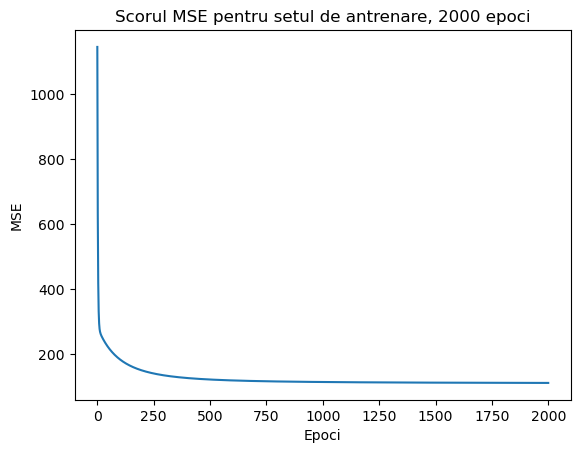

In [22]:
plt.plot(mses_train)
plt.title(f'Scorul MSE pentru setul de antrenare, {n_epochs} epoci')
plt.xlabel('Epoci')
plt.ylabel('MSE')
plt.show()

## Model de regresie liniara determinat prin metoda ecuatiilor normale

Pentru regresia liniara exista o metoda analitica de determinare a coeficientilor $\boldsymbol{\theta}$ bazata pe metoda ecuatiilor normale. Pentru un set de date $X_{train}$ (nu neaparat cu coloanele scalate in intervalul [0, 1]) si un set de valori de iesire (ground truth) asociate $y_{train}$, vectorul de coeficienti se determina cu:
$$
\boldsymbol{\theta} = \left(X_{train}^t \cdot X_{train}\right)^{-1}\cdot X_{train} \cdot y
$$

Expresia $X_{train} ^ \dagger = \left(X_{train}^t \cdot X_{train}\right)^{-1}\cdot X_{train}$ se numeste pseudo inversa Moore-Penrose a lui $X_{train}$. Pentru calculul ei se foloseste functia [numpy.linalg.pinv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html).

In [23]:
# calculeaza vectorul theta_norm folosind functia np.linalg.pinv
theta_norm:np.ndarray = np.dot(np.linalg.pinv(X_train), y_train)
# evalueaza modelul construit cu vectorul theta_norm pe setul de antrenare nescalat
mse_norm_train:float = eval_model(X_train, y_train, theta_norm)
# evalueaza modelul construit cu vectorul theta_norm pe setul de testare nescalat
mse_norm_test:float = eval_model(X_test, y_test, theta_norm)
# evalueaza modelul construit cu vectorul theta (folosidn metoda gradient descent) pe setul de antrenare scalat
mse_grad_test:float = eval_model(X_train_scaled, y_train, theta)

print(f'MSE pe set de antrenare, cu metoda gradient descent: {mses_train[-1]}')
print(f'MSE pe set de antrenare, cu metoda ecuatiilor normale: {mse_norm_train}')

print(f'MSE pe set de testare, cu metoda gradient descent: {mse_grad_test}')
print(f'MSE pe set de testare, cu metoda ecuatiilor normale: {mse_norm_test}')

MSE pe set de antrenare, cu metoda gradient descent: 112.06478435353691
MSE pe set de antrenare, cu metoda ecuatiilor normale: 110.7779902085299
MSE pe set de testare, cu metoda gradient descent: 112.06478435353691
MSE pe set de testare, cu metoda ecuatiilor normale: 102.73965133120751


## Intrebari

Intrebarile din aceasta sectiune sunt optionale, dar tratarea lor este utila pentru intelegerea mai buna a materialului.

1. Vectorii `min_cols` si `max_cols` determinati pe setul de antrenare se aplica pe setul de testare. Puteti explica de ce dupa acest pas, pe setul de testare valorile minime si maxime de coloane nu sunt 0, respectiv 1?
Scalarea se face relativ la valorile de pe setul de antrenare. Deoarece setul de testare poate avea o distributie a datelor diferita si valori minime si maxime diferite, acest lucru poate duce la valori mai mici sau mai mari decat 0 si 1.

2. Daca rulam de mai multe ori codul de mai sus, vectorii `theta_norm` si `theta` au de fiecare data valori diferite. De ce? Considerati efectul functiei  `split_train_test`. 
Ruland de mai multe ori, functia split_train_test va impartii in functie de un procent random, generat per rulare. Din aceasta cauza, impartirea seturilor de antrenare si testare va fi diferita.

3. Cum puteti asigura reproductibilitatea - obtinerea acelorasi rezulatte - la rulari diferite?
Putem impartii seturile de antrenare si testare dupa un procent constant, nu unul generat random.

4. Obtineti vectorul de valori MSE evaluate la fiecare epoca pe setul de testare si reprezentati pe acelasi grafic valoarea functiei de eroare atat pentru setul de antrenare, cat si pentru setul de testare. In implementarea curenta valoarea functiei de eroare pe setul de testare se determina la fiecare `log_interval` pasi.
? uh am i supposed to modify code here ?

5. Rulati codul pentru valorile ne-scalate ale matricelor X_train si X_test. Ce observati?
Lipsa valorilor ne-scalate duce la ingreunarea invatarii corecte a datelor. (uh maybe rephrase this one it's kinda ambiguous)

6. Rulati codul folosind valorile scalate ale matricelor X_train si X_test, dar fara adaugarea unei coloane de 1. Comparati valorile de eroare pe seturile de antrenare si de testare pentru cele doua rulari: cu si fara coloana de 1. \
Daca nu se adauga coloana de 1 algoritmul nu poate invata sa aproximeze corect termenul liber, astfel invatand doar relatii liniare care trec prin originea coordonatelor.